# Quantum Fourier Transform

In this notebook, we'll be implementing the Quantum Fourier Transform from scratch.

It's well known for its use in Quantum Phase Estimation (and therefore Shor's algorithm.)

Let's get started.

In [1]:
%pip install qiskit[visualization] --quiet
%pip install matplotlib --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


As a quick reminder: the Fourier transform takes a vector and identifies the different periodicities therein.

Whereas the classical Discrete Fourier Transform takes a vector in real space $\vec{v}$ to a vector in frequency space $\vec{\tilde{v}}$, the QFT gets a quantum superposition of the $N=2^n$ basis vectors $|k\rangle$ of $n$ qubits: $\sum_{k=0} v_k |k\rangle$ and transforms this superposition such that the coefficients are now what would be the values of the frequency-domain vector $\sum_{j=0} \tilde{v}_j |j\rangle$. For a generic state, the QFT acts as 

$$ QFT(\sum_{k=0} v_k |k\rangle) = \sum_{j=0} \tilde{v}_j |j\rangle$$

Therefore, we need to transform each basis state $|j\rangle$ as:

$$ |j\rangle \to \frac{1}{\sqrt{N}}\sum_{k=~0}^{N-1} e^{2\pi i j k/N} |k\rangle$$

## Implementation

We can implement this transformation using a straightforward trick: there is an equivalent representation of the above transformation. We need a couple notational tricks firts. We expand the notation of the basis state $|j\rangle$ as $|j_1 j_2 j_3 ... j_n\rangle$ where $n$ is the number of qubits, and $j_k \in \{0,1\}$. Then, we define a new notation: $0.j_{\ell}j_{\ell+1} ... j_m$ means $j_{\ell}/2 + j_{\ell+1}/4 + ... + j_m/2^{m-\ell+1}$. Finally, we can rewrite the effect of the QFT as 


$$ |j\rangle \to \frac{1}{\sqrt{N}}\sum_{k=~0}^{N-1} e^{2\pi i j k/N} |k\rangle = \frac{1}{\sqrt{N}}\left(|0\rangle + e^{2\pi i0.j_n}|1\rangle\right)\left(|0\rangle + e^{2\pi i0.j_{n-1}j_{n}}|1\rangle\right)\cdots\left(|0\rangle + e^{2\pi i0.j_1j_2...j_n}|1\rangle\right)$$

(Exercise: prove it. Alternatively, read section 5.1 of the Nielsen-Chuang)

Now it's fairly clear how to implement the QFT: we need to apply the correct phases to the $|1\rangle$ state of each qubit. To this end, we only need two kinds of gates, and one of them, the Hadamard, is already implemented in qiskit. 

We need a second (parametrized) gate to apply the phases: the controlled-$R_k$ gate (for which $k$ can be picked) applies a phase of $e^{2\pi i/2^{k}}$ to $|1\rangle$ (it's also known as the CPhaseGate):

$$\textrm{controlled-}R_k =  \begin{pmatrix}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & e^{2\pi i/2^{k}}\end{pmatrix}$$

In the code, $R_k$ takes two parameters: the control and the target qubits, and that tells us which qubit controls the phase and which qubit gets it: $R_k(ctrl,targ)$

Of course, this is your job. I've merely written the helpers, but you need to write down the matrix.

In [52]:
from qiskit.circuit.library import UnitaryGate
from qiskit import QuantumCircuit
import numpy as np

def Rk(k:int)->UnitaryGate:

    # EXERCISE: write down the matrix!
    rk_mat=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,np.exp(2j*np.pi/(2**k))]])
    return UnitaryGate(rk_mat)

def apply_controlled_rk(circ:QuantumCircuit,k:int,ctrl:int,targ:int)->None:
    rk = Rk(k)
    circ.append(rk,[ctrl,targ])


Now, we must build the circuit. 

There's a few pitfalls to avoid when building the QFT. 

The first one is that the common definition of the QFT is in fact the inverse of the Fourier transform. Fortunately, the inverse of a unitary is simply the reverse circuit. So, if we want to apply the transform from real space to frequency space, we need to use the _inverse Quantum Fourier Transform_ (iQFT) by simply appending the `circuit.inverse()` function when we're done: it flips the circuit backwards and negates all phases. It's that easy.

The second one is due to the right-to-left ordering of bitstrings in qiskit. The decimal notation ($0.j_1j_2...$) we introduced above needs to be applied from the last qubit up to the first, backwards from what we usually see in diagrams. Or, if it's simpler, you can also create the circuit from 0 to $n-1$ (which avoids nasty indexing issues), and finally apply the function `circuit.reverse_bits()` to "flip" the circuit upside down.

The third and final issue is that the QFT actually flips the result at the end, and it must be disentangled. Which means we need to use `circuit.swap(i,j)` to swap back the qubits, swap $q_0$ with $q_{n-1}$, $q_1$ with $q_{n-2}$, $q_2$ with $q_{n-3}$ and so on until $q_{n/2-1}$ and $q_{n/2+1}$ This is done before we reverse the ops on the circuit.

Now that we know the issues ahead, let's describe the actual circuit. 

Here is how we apply all the correct phases. I will describe the version from $0$ to $n-1$, as the indexing is much easier to understand. You can implement this version straight away and use the `reverse_bits` function, or translate it to the reverse indexing scheme and implement that instead. 

So. If we start with qubit $q_0$, we want a phase of $0.j_1...j_{n-1}$ on the $|1\rangle$. This simply means we want to first apply a Hadamard on $q_0$ (to get the superposition), and then $n-2$ controlled-$R_k$ gates with $k=1,..,n-1$, using qubits $q_1,...q_{n-1}$ as controls. Moving to qubit $q_1$, we apply the same scheme, except we apply $n-3$ controlled gates. Beware though, the $k$ still starts at $1$, since we want the phase $k$ to be difference between the target qubit index and the control qubit index, meaning that, for example, $R_k(q_2,q_1)$ has a phase of $k=1$, since $k = 2-1=1$. 

And so on, until we reach $q_{n-2}$: this case is probably the most insightful. We simply want a phase of $0.j_{n-1}$. We apply a Hadamard, and then $R_1$ ($k=(n-1)-(n-2)=1$). This gives us a phase of $1/2$ (which $0.j_{n-1}$ represents if you recall what the notation means.) It is plain to see that applying $R_1(q_{n_1},q_{n-2})$ indeed gets us $|0\rangle + e^{-i\pi/2}

In the end, there is no qubit beyond $q_{n-1}$, so we have no controlled phase to apply: $q_{n-1}$ only gets a Hadamard.

Anyway, in the next exercise, you need to create the QFT circuit. I've written the functions to check that it is correct. The rest is up to you.

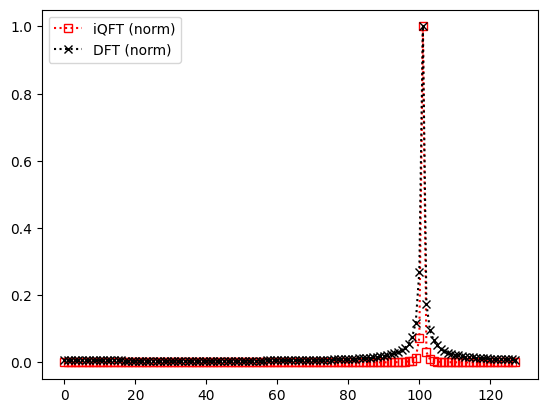

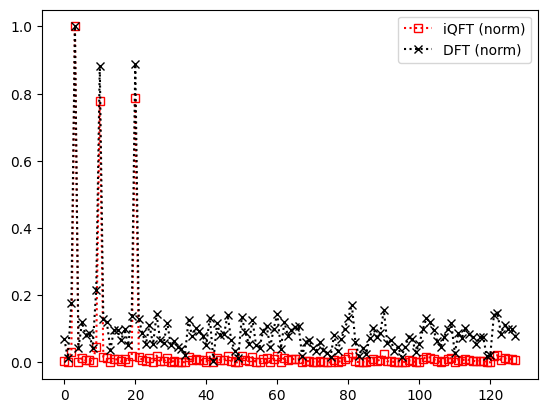

In [57]:
from scipy.fft import fft
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt

def build_qft_circuit(n_qubits:int)->QuantumCircuit:
    # EXERCISE: write the QFT circuit!
    # TIP: use two for loops
    # TIP 2: don't forget the swaps!
    # TIP 3: depending on how you implement the circuit, you might need to apply a phase of (k+1) rather than k!
    circuit = QuantumCircuit(n_qubits)
    for n in range(n_qubits):
        circuit.h(n)
        for j in range(n+1,n_qubits):
            apply_controlled_rk(circuit,j-n+1,j,n)
    for q in range(n_qubits//2):
        circuit.swap(q,n_qubits-1-q)
    circuit = circuit.reverse_bits()
    circuit = circuit.inverse()
    return circuit

def get_qft_coefficients(n_qubits:int,initial_state:np.ndarray)->np.ndarray:
    circuit = QuantumCircuit(n_qubits)
    circuit.prepare_state(state=initial_state)
    qft_circuit = build_qft_circuit(n_qubits)

    circuit.append(qft_circuit,qargs=range(n_qubits))
    statevector = Statevector.from_instruction(circuit)
    return statevector.probabilities()
    

def check_results(initial_state:np.ndarray,n_qubits:int)->None:
    
    fft_amplitudes = fft(initial_state,len(initial_state))
    amplitudes=get_qft_coefficients(n_qubits,initial_state)
    
    plt.plot(range(len(amplitudes)),np.abs(amplitudes)/np.max(np.abs(amplitudes)),"rs:",markerfacecolor='none',label="iQFT (norm)")
    plt.plot(range(len(amplitudes)),np.abs(fft_amplitudes)/np.max(np.abs(fft_amplitudes)),"kx:",label="DFT (norm)")
    plt.legend()
    plt.show()


n_qubits=7

# SIMPLE VECTOR: frequency of 100
initial_state = np.exp(1j*100*np.pi*np.linspace(0,2,2**n_qubits))
initial_state/=np.linalg.norm(initial_state)
check_results(initial_state,n_qubits=n_qubits)


# HARMONICS VECTOR + NOISE: frequencies of 3, 10, 20 + random noise
initial_state = np.exp(1j*2*np.pi*np.random.rand(2**n_qubits))
initial_state += np.exp(1j*np.pi*3*np.linspace(0,2,2**n_qubits))
initial_state += np.exp(1j*np.pi*10*np.linspace(0,2,2**n_qubits))
initial_state += np.exp(1j*np.pi*20*np.linspace(0,2,2**n_qubits))
initial_state/=np.linalg.norm(initial_state)
check_results(initial_state,n_qubits=n_qubits)



In the end, we get the QFT, with, as expected, a gate depth that is exponentially better than classical complexity. Yet, since we cannot directly measure all the coefficients, it is not so straightforward to build quantum advantage using the QFT. Next week, we'll look at Quantum Phase Estimation which delivers an advantage by using the QFT in a clever way.